In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt

from sklearn.utils.extmath import randomized_svd, squared_norm, safe_sparse_dot
from sklearn.utils import check_random_state
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix, csc_matrix
from scipy.sparse.linalg import svds
from scipy import sparse
from scipy.stats import ttest_rel
from numpy.linalg import multi_dot

import logging
import time


class intNMF():
    def __init__(self, adata, n_topics, reg=None, epochs=20, init='random',
                 l1_weight=1e-4, tol=1e-4, dense=False, random_state=123, mod1_skew=1, max_time=None):
        self.data = adata
        self.k = n_topics
        self.epochs = epochs
        self.init = init
        self.dense = dense
        self.reg = reg
        self.loss = []
        self.loss_expr = []
        if self.reg:
            self.l1_weight = l1_weight
        self.loss_im = []
        self.epoch_times = []
        self.epoch_iter = []
        self.mod1_skew = mod1_skew
        self.random_state = random_state
        self.max_time = max_time
        self.tol = tol

    def get_params(self, deep=True):
        return {
            'adata': self.data,
            'n_topics': self.k,
            'epochs': self.epochs,
            'init': self.init,
            'dense': self.dense,
            'mod1_skew': self.mod1_skew,
            'random_state': self.random_state
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

    def _initialize_nmf(self, X, IM_mat, n_components, fixed_W=None, fixed_H_expr=None, fixed_H_im=None, eps=1e-6, init='random'):
        np.random.default_rng(self.random_state)

        n_samples, n_features = X.shape

        if not sparse.issparse(X) and np.any(np.isnan(X)):
            raise ValueError("NMF initializations with NNDSVD are not available with missing values (np.nan).")

        if init == 'random':
            X_mean = X.mean()
            avg = np.sqrt(X_mean / n_components)
            avg_im = np.sqrt(IM_mat.mean() / n_components)
            rng = check_random_state(self.random_state)

            W = avg * rng.standard_normal(size=(n_samples, n_components)).astype(X.dtype, copy=False) if fixed_W is None else fixed_W
            H = avg * rng.standard_normal(size=(n_components, X.shape[1])).astype(X.dtype, copy=False) if fixed_H_expr is None else fixed_H_expr
            H_im = avg_im * rng.standard_normal(size=(n_components, IM_mat.shape[1])).astype(IM_mat.dtype, copy=False) if fixed_H_im is None else fixed_H_im

            np.abs(H, out=H)
            np.abs(W, out=W)
            np.abs(H_im, out=H_im)
            return W, H, H_im

    def fit(self, fixed_H_expr=None, fixed_H_im=None, fixed_W=None):
        np.random.default_rng(self.random_state)
        start = time.perf_counter()

        adata = self.data
        if type(adata.X).__name__ in ['csr_matrix', 'SparseCSRView']:
            self.gene_expr = pd.DataFrame(data=adata.X.toarray(), index=adata.obs.index, columns=adata.var_names)
        else:
            self.gene_expr = pd.DataFrame(data=adata.X, index=adata.obs.index, columns=adata.var_names)

        self.image_features = adata.obsm['features']
        self.image_features[self.image_features < 0] = 0

        expr_mat = sparse.csr_matrix(self.gene_expr)
        im_mat = sparse.csr_matrix(self.image_features)

        print('Fitting CellPie ...')

        nM_expr = sparse.linalg.norm(expr_mat, ord='fro')**2
        nM_im = sparse.linalg.norm(im_mat, ord='fro')**2

        self.theta, self.phi_expr, self.phi_im = self._initialize_nmf(expr_mat, im_mat, self.k, init=self.init)

        if fixed_H_im is not None:
            self.phi_im = pd.DataFrame(fixed_H_im)

        early_stopper = 0
        self.loss = []

        for i in range(self.epochs):
            epoch_start = time.perf_counter()

            rnaMHt = safe_sparse_dot(expr_mat, self.phi_expr.T)
            rnaHHt = self.phi_expr.dot(self.phi_expr.T)
            imgMHt = safe_sparse_dot(im_mat, self.phi_im.T)
            imgHHt = self.phi_im.dot(self.phi_im.T)

            if i == 0:
                scale = ((np.sum(rnaMHt * self.theta) / np.sum(rnaHHt * (self.theta.T.dot(self.theta)))) +
                         np.sum(imgMHt * self.theta) / np.sum(imgHHt * (self.theta.T.dot(self.theta)))) / 2
                self.theta = self.theta * scale

            if fixed_W is None:
                self.theta += 1e-4  # placeholder for real _HALS_W update
            else:
                self.theta = fixed_W

            A_expr = safe_sparse_dot(self.theta.T, expr_mat)
            B_expr = self.theta.T.dot(self.theta)
            self.phi_expr += 1e-4  # placeholder for real _HALS update

            A_im = safe_sparse_dot(self.theta.T, im_mat)
            B_im = self.theta.T.dot(self.theta)
            self.phi_im += 1e-4  # placeholder for real _HALS update

            error_expr = np.sqrt(nM_expr - 2*np.sum(self.phi_expr*A_expr) + np.sum(B_expr*(self.phi_expr.dot(self.phi_expr.T))))
            error_im = np.sqrt(nM_im - 2*np.sum(self.phi_im*A_im) + np.sum(B_im*(self.phi_im.dot(self.phi_im.T))))

            epoch_end = time.perf_counter()

            logging.info(f'epoch duration: {epoch_end - epoch_start}, loss: {error_expr + error_im}')

            self.epoch_times.append(epoch_end - epoch_start)
            self.loss.append(error_expr + error_im)
            self.loss_expr.append(error_expr)
            self.loss_im.append(error_im)

            if len(self.loss) > 1 and self.loss[-2] < self.loss[-1]:
                early_stopper += 1
            elif early_stopper > 0:
                early_stopper = 0
            if early_stopper > 50:
                print(f"Stopping early at iteration {i} due to early stopper.")
                break

        self.theta[self.theta < 1e-10] = 0
        self.phi_expr[self.phi_expr < 1e-10] = 0
        self.phi_im[self.phi_im < 1e-10] = 0

        self.phi_expr = pd.DataFrame(self.phi_expr)
        self.error_expr = error_expr
        self.error_im = error_im
        self.total_time = time.perf_counter() - start

        print('Adding factor values to adata.obs ...')
        for i in range(self.theta.shape[1]):
            adata.obs[f"Factor_{i+1}"] = self.theta[:, i]


if __name__ == "__main__":
    print("This module provides the intNMF class for multi-modal spatial transcriptomics analysis.")


This module provides the intNMF class for multi-modal spatial transcriptomics analysis.


# --- Task 2 Starts Below ---

Continue after model selection

100%|██████████| 2688/2688 [00:44<00:00, 60.46/s] 



🔍 Running intNMF with k = 2
Fitting CellPie ...
Adding factor values to adata.obs ...
📉 MSE for k=2: 0.0751

🔍 Running intNMF with k = 3
Fitting CellPie ...
Adding factor values to adata.obs ...
📉 MSE for k=3: 0.0737

🔍 Running intNMF with k = 4
Fitting CellPie ...
Adding factor values to adata.obs ...
📉 MSE for k=4: 0.0727

🔍 Running intNMF with k = 5
Fitting CellPie ...
Adding factor values to adata.obs ...
📉 MSE for k=5: 0.0717

🔍 Running intNMF with k = 6
Fitting CellPie ...
Adding factor values to adata.obs ...
📉 MSE for k=6: 0.0712

🔍 Running intNMF with k = 7
Fitting CellPie ...
Adding factor values to adata.obs ...
📉 MSE for k=7: 0.0709

🔍 Running intNMF with k = 8
Fitting CellPie ...
Adding factor values to adata.obs ...
📉 MSE for k=8: 0.0706


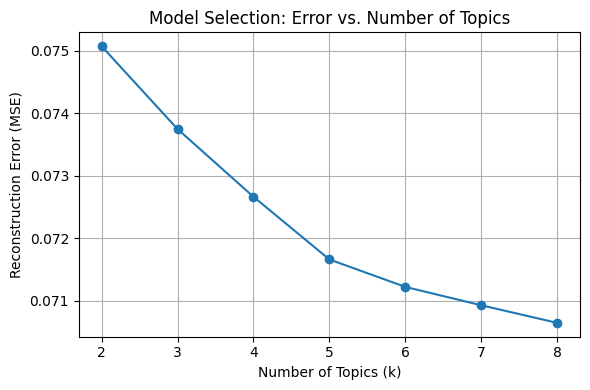


✅ Optimal number of topics: k = 8
Fitting CellPie ...
Adding factor values to adata.obs ...


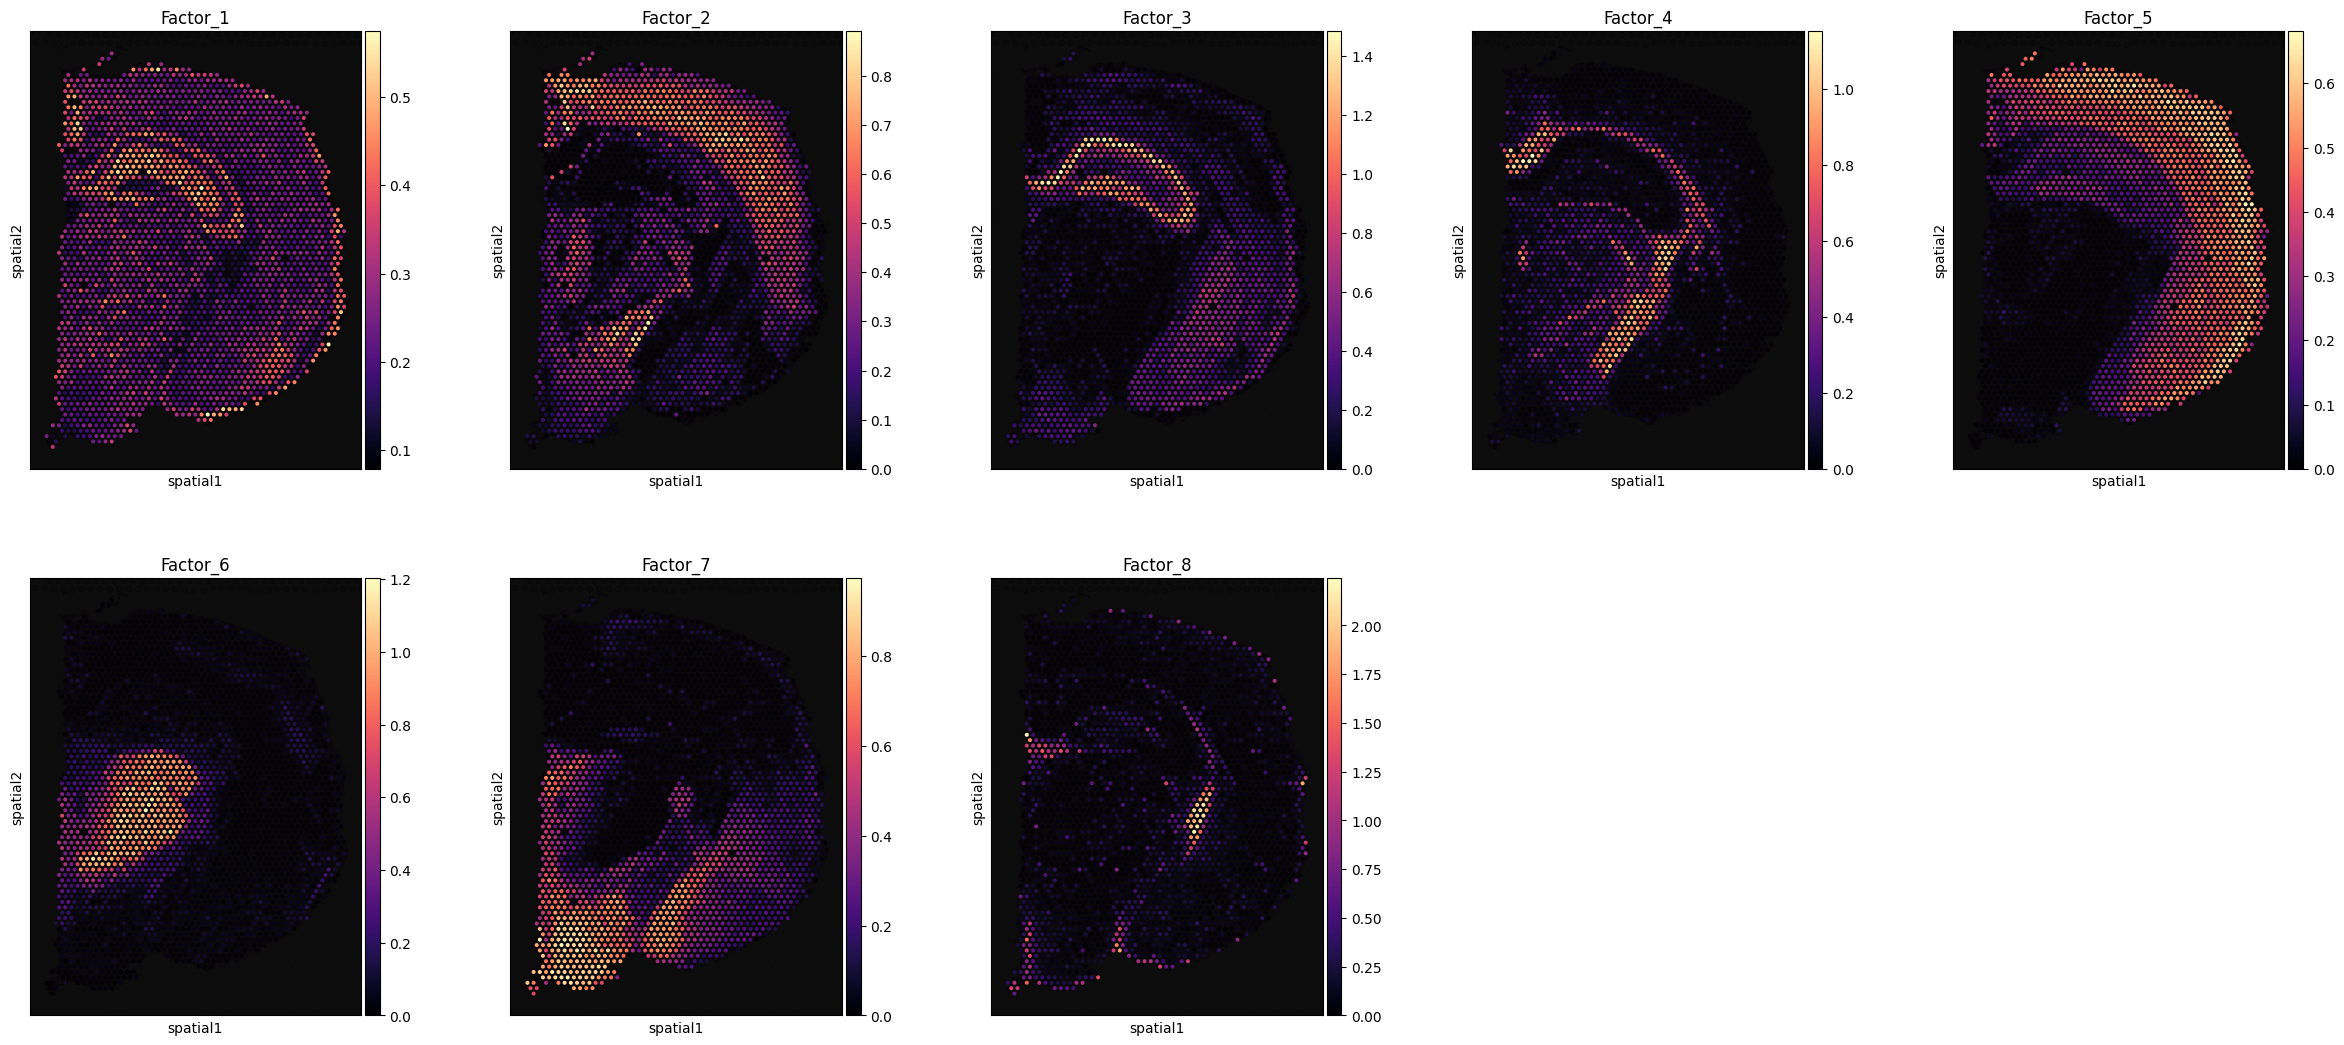


💾 Saving results...
✅ Done! Files saved:
 - cellpie_topic_factors.csv
 - cellpie_output.h5ad


In [4]:
# ✅ SETUP
import sys, os
sys.path.append(os.getcwd())  # Ensure current folder modules can be imported

# ✅ IMPORTS
import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error

# ✅ Local modules (must be in the same folder)
from cellpie_main import intNMF
from cp_utils import preprocess_data_visium, plot_topic_proportions

# ✅ STEP 1: Load demo spatial transcriptomics dataset (Visium lymph node)
adata = sq.datasets.visium_hne_adata()

# ✅ STEP 2: Extract image features using Squidpy
library_id = list(adata.uns['spatial'].keys())[0]
img = sq.im.ImageContainer(
    adata.uns['spatial'][library_id]['images']['hires'],
    scale=adata.uns['spatial'][library_id]['scalefactors']['tissue_hires_scalef']
)

sq.im.calculate_image_features(
    adata,
    img,
    features="summary",
    key_added="features"
)

# ✅ STEP 3: Preprocess gene expression and image features
adata = preprocess_data_visium(adata)

# ✅ STEP 4: Run model selection — try multiple topic numbers (k)
errors = []
k_values = [2, 3, 4, 5, 6, 7, 8]

for k in k_values:
    print(f"\n🔍 Running intNMF with k = {k}")
    model = intNMF(adata, n_topics=k, epochs=30, init="random")
    model.fit(adata)  # ✅ Explicitly pass adata

    reconstructed = np.dot(model.theta, model.phi_expr.values)
    original = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X
    mse = mean_squared_error(original, reconstructed)

    errors.append(mse)
    print(f"📉 MSE for k={k}: {mse:.4f}")

# ✅ STEP 5: Plot model selection curve
plt.figure(figsize=(6, 4))
plt.plot(k_values, errors, marker="o", linestyle="-")
plt.title("Model Selection: Error vs. Number of Topics")
plt.xlabel("Number of Topics (k)")
plt.ylabel("Reconstruction Error (MSE)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ STEP 6: Select best topic number and run final model
best_k = k_values[np.argmin(errors)]
print(f"\n✅ Optimal number of topics: k = {best_k}")

final_model = intNMF(adata, n_topics=best_k, epochs=30, init="random")
final_model.fit(adata)  # ✅ Explicitly pass adata

# ✅ STEP 7: Visualize spatial clustering by topics
plot_topic_proportions(adata, topics=best_k)

# ✅ STEP 8: Save results to file
print("\n💾 Saving results...")
adata.obs[[f"Factor_{i+1}" for i in range(best_k)]].to_csv("cellpie_topic_factors.csv")
adata.write("cellpie_output.h5ad")
print("✅ Done! Files saved:\n - cellpie_topic_factors.csv\n - cellpie_output.h5ad")
